In [ ]:

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [ ]:
import matplotlib.pyplot as plt 
from bliss.encoders.autoencoder import OneCenteredGalaxyAE
import torch
import numpy as np

import pytorch_lightning as L

from bliss.datasets.table_utils import column_to_tensor
from bliss.datasets.lsst import prepare_final_galaxy_catalog, prepare_final_star_catalog, get_default_lsst_psf
from astropy.table import Table

In [ ]:
ae = OneCenteredGalaxyAE().eval()
ae.load_state_dict(torch.load("../../models/autoencoder_42.pt", weights_only=True))

<All keys matched successfully>

In [ ]:

from bliss.encoders.deblend import GalaxyEncoder


model = GalaxyEncoder("../../models/autoencoder_42.pt", lr=1e-5)

In [ ]:
_cat = Table.read("../../../data/OneDegSq.fits")
_star_mags = column_to_tensor(Table.read("../../../data/stars_med_june2018.fits"),"i_ab")
# CATSIM_CAT = prepare_final_galaxy_catalog(_cat)
CATSIM_CAT = _cat[_cat['i_ab'] < 22]
STAR_MAGS = prepare_final_star_catalog(_star_mags)

PSF = get_default_lsst_psf()

In [ ]:
# get some blends
from bliss.datasets.generate_blends import generate_dataset


ds = generate_dataset(10, CATSIM_CAT, STAR_MAGS, PSF, 10, slen=40, galaxy_density=200, star_density=0, add_galaxies_in_padding=False)

100%|██████████| 10/10 [00:00<00:00, 27.58it/s]


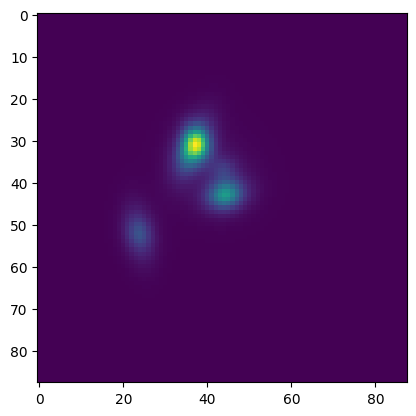

In [ ]:
idx = 8
plt.imshow(ds['noiseless'][idx,  0]  - ds['paddings'][idx, 0])

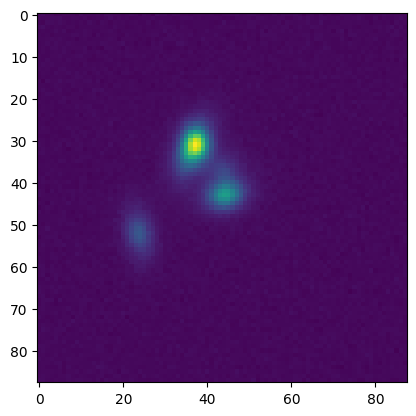

In [ ]:
plt.imshow(ds['images'][idx, 0])

In [ ]:

import torch
from torch import Tensor
from torch.utils.data import Dataset

from bliss.catalog import FullCatalog


class BlendBatches(Dataset):
    def __init__(
        self,
        ds: dict,
        slen: int = 40,
        tile_slen: int = 4,
        keep_padding: bool = False,
    ) -> None:
        super().__init__()

        self.images = ds.pop("images").float()  # needs to be a float for NN
        self.background = ds.pop("background").float()
        self.epoch_size = len(self.images)

        # don't need for training
        ds.pop("centered_sources")
        ds.pop("uncentered_sources")
        ds.pop("noiseless")

        # avoid large memory usage if we don't need padding.
        if not keep_padding:
            ds.pop("paddings")
            self.paddings = torch.tensor(0.).float()
        else:
            self.paddings = ds.pop("paddings").float()
        self.keep_padding = keep_padding

        full_catalog = FullCatalog(slen, slen, ds)
        tile_catalogs = full_catalog.to_tile_params(tile_slen, ignore_extra_sources=True)
        self.tile_params = tile_catalogs.to_dict()

    def __len__(self) -> int:
        return self.epoch_size

    def __getitem__(self, index) -> dict[str, Tensor]:
        tile_params_ii = {p: q[index] for p, q in self.tile_params.items()}
        return {
            "images": self.images[index],
            "background": self.background[index],
            "paddings": self.paddings[index] if self.keep_padding else self.paddings,
            **tile_params_ii,
        }

In [ ]:
# # overfit deblender to this once source


# trainer = L.Trainer(
#     limit_train_batches=1.0,
#     max_epochs=20,
#     accelerator="cpu",
#     devices=1,
#     check_val_every_n_epoch=1000000,
#     log_every_n_steps=10,
# )


In [ ]:
from torch.utils.data import DataLoader, Dataset

train_ds = BlendBatches({**ds}, keep_padding=True)
val_ds = BlendBatches({**ds}, keep_padding=True)

train_dl = DataLoader(train_ds, batch_size=10, shuffle=True, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=10, num_workers=0)


In [ ]:
paddings

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [ ]:

from torch.optim import Adam
from tqdm import tqdm

from bliss.datasets.generate_blends import parse_dataset

# gpu 
gpu = torch.device("cuda:0")
model = model.to(gpu)

opt = Adam(model.parameters(), lr=1e-3)
loss_iter = []


for ii in tqdm(range(1000), desc='epoch:'):

    # train 
    running_loss = 0.
    running_locs_loss = 0.
    running_counter_loss = 0.
    train_n_batches = 0
    model.train()
    for tbatch in train_dl:
        opt.zero_grad()
        images, background, truth_cat, paddings = parse_dataset(tbatch)
        images= images.to(gpu)
        background = background.to(gpu)
        truth_cat = truth_cat.to(gpu)
        paddings = paddings.to(gpu)
        loss = model.get_loss(images, paddings, background, truth_cat)
        loss.backward()
        opt.step()

        running_loss += loss.detach().cpu().item()
        train_n_batches+=1 

    running_loss /= train_n_batches
    loss_iter.append(running_loss)

    if ii % 10 == 4:

        print('epoch:', ii, ',training_loss: ', running_loss)

epoch::   1%|▏         | 14/1000 [00:00<00:21, 45.90it/s]

epoch: 4 ,training_loss:  7292230.0


epoch::   2%|▎         | 25/1000 [00:00<00:20, 48.54it/s]

epoch: 14 ,training_loss:  4053933.5
epoch: 24 ,training_loss:  2670117.75


epoch::   4%|▍         | 43/1000 [00:00<00:18, 52.40it/s]

epoch: 34 ,training_loss:  1936588.25
epoch: 44 ,training_loss:  1691033.75


epoch::   6%|▌         | 61/1000 [00:01<00:16, 55.61it/s]

epoch: 54 ,training_loss:  1584028.5
epoch: 64 ,training_loss:  1497959.125


epoch::   8%|▊         | 82/1000 [00:01<00:15, 59.55it/s]

epoch: 74 ,training_loss:  1419567.5
epoch: 84 ,training_loss:  1348076.75


epoch::  10%|█         | 103/1000 [00:01<00:14, 61.14it/s]

epoch: 94 ,training_loss:  1272761.25
epoch: 104 ,training_loss:  1198232.0


epoch::  12%|█▏        | 124/1000 [00:02<00:14, 62.05it/s]

epoch: 114 ,training_loss:  1124708.5
epoch: 124 ,training_loss:  1057429.0


epoch::  14%|█▍        | 145/1000 [00:02<00:13, 62.47it/s]

epoch: 134 ,training_loss:  999107.75
epoch: 144 ,training_loss:  951110.9375


epoch::  17%|█▋        | 166/1000 [00:02<00:13, 63.41it/s]

epoch: 154 ,training_loss:  911310.625
epoch: 164 ,training_loss:  877102.75


epoch::  19%|█▊        | 187/1000 [00:03<00:12, 62.76it/s]

epoch: 174 ,training_loss:  847705.125
epoch: 184 ,training_loss:  821469.1875


epoch::  21%|██        | 208/1000 [00:03<00:12, 64.15it/s]

epoch: 194 ,training_loss:  801718.125
epoch: 204 ,training_loss:  786045.25


epoch::  22%|██▏       | 222/1000 [00:03<00:12, 64.73it/s]

epoch: 214 ,training_loss:  772509.875
epoch: 224 ,training_loss:  760771.0625


epoch::  24%|██▍       | 243/1000 [00:04<00:11, 64.17it/s]

epoch: 234 ,training_loss:  750499.0
epoch: 244 ,training_loss:  741185.5625


epoch::  26%|██▋       | 264/1000 [00:04<00:11, 64.75it/s]

epoch: 254 ,training_loss:  732491.5
epoch: 264 ,training_loss:  724822.0


epoch::  28%|██▊       | 285/1000 [00:04<00:11, 64.35it/s]

epoch: 274 ,training_loss:  717884.8125
epoch: 284 ,training_loss:  711937.6875


epoch::  31%|███       | 306/1000 [00:05<00:10, 63.88it/s]

epoch: 294 ,training_loss:  707055.5
epoch: 304 ,training_loss:  702618.125


epoch::  33%|███▎      | 327/1000 [00:05<00:10, 64.84it/s]

epoch: 314 ,training_loss:  698588.75
epoch: 324 ,training_loss:  694977.6875


epoch::  34%|███▍      | 341/1000 [00:05<00:10, 64.39it/s]

epoch: 334 ,training_loss:  691667.75
epoch: 344 ,training_loss:  688231.1875


epoch::  36%|███▌      | 362/1000 [00:05<00:09, 64.27it/s]

epoch: 354 ,training_loss:  684623.125
epoch: 364 ,training_loss:  681513.6875


epoch::  38%|███▊      | 383/1000 [00:06<00:09, 64.40it/s]

epoch: 374 ,training_loss:  678802.75
epoch: 384 ,training_loss:  676367.75


epoch::  40%|████      | 405/1000 [00:06<00:08, 66.57it/s]

epoch: 394 ,training_loss:  674391.25
epoch: 404 ,training_loss:  672660.3125


epoch::  43%|████▎     | 426/1000 [00:06<00:08, 67.23it/s]

epoch: 414 ,training_loss:  671033.375
epoch: 424 ,training_loss:  669600.25


epoch::  45%|████▍     | 447/1000 [00:07<00:08, 67.48it/s]

epoch: 434 ,training_loss:  668258.625
epoch: 444 ,training_loss:  666977.625


epoch::  47%|████▋     | 468/1000 [00:07<00:08, 65.90it/s]

epoch: 454 ,training_loss:  665816.75
epoch: 464 ,training_loss:  664710.0


epoch::  48%|████▊     | 482/1000 [00:07<00:07, 64.80it/s]

epoch: 474 ,training_loss:  663695.5625
epoch: 484 ,training_loss:  662741.875


epoch::  50%|█████     | 503/1000 [00:08<00:07, 65.52it/s]

epoch: 494 ,training_loss:  661851.375
epoch: 504 ,training_loss:  661031.8125


epoch::  52%|█████▏    | 524/1000 [00:08<00:07, 64.42it/s]

epoch: 514 ,training_loss:  660132.125
epoch: 524 ,training_loss:  659273.5


epoch::  55%|█████▍    | 545/1000 [00:08<00:06, 65.03it/s]

epoch: 534 ,training_loss:  657400.8125
epoch: 544 ,training_loss:  654526.5625


epoch::  57%|█████▋    | 566/1000 [00:09<00:07, 60.60it/s]

epoch: 554 ,training_loss:  652943.375
epoch: 564 ,training_loss:  651980.25


epoch::  58%|█████▊    | 585/1000 [00:09<00:07, 57.43it/s]

epoch: 574 ,training_loss:  651285.125
epoch: 584 ,training_loss:  650632.75


epoch::  60%|██████    | 603/1000 [00:09<00:07, 55.05it/s]

epoch: 594 ,training_loss:  650090.25
epoch: 604 ,training_loss:  649640.5


epoch::  62%|██████▏   | 621/1000 [00:10<00:06, 54.76it/s]

epoch: 614 ,training_loss:  649241.9375
epoch: 624 ,training_loss:  648859.125


epoch::  64%|██████▍   | 645/1000 [00:10<00:06, 56.12it/s]

epoch: 634 ,training_loss:  648508.8125
epoch: 644 ,training_loss:  648203.5


epoch::  66%|██████▋   | 663/1000 [00:10<00:06, 55.14it/s]

epoch: 654 ,training_loss:  647949.1875
epoch: 664 ,training_loss:  647706.75


epoch::  68%|██████▊   | 681/1000 [00:11<00:05, 54.57it/s]

epoch: 674 ,training_loss:  647473.0625
epoch: 684 ,training_loss:  647240.5


epoch::  70%|███████   | 705/1000 [00:11<00:05, 55.31it/s]

epoch: 694 ,training_loss:  647017.625
epoch: 704 ,training_loss:  646781.3125


epoch::  72%|███████▏  | 723/1000 [00:11<00:04, 55.74it/s]

epoch: 714 ,training_loss:  646557.4375
epoch: 724 ,training_loss:  646357.8125


epoch::  74%|███████▍  | 741/1000 [00:12<00:04, 54.77it/s]

epoch: 734 ,training_loss:  646167.8125
epoch: 744 ,training_loss:  645974.9375


epoch::  76%|███████▋  | 765/1000 [00:12<00:04, 53.67it/s]

epoch: 754 ,training_loss:  645811.5
epoch: 764 ,training_loss:  645675.0625


epoch::  78%|███████▊  | 783/1000 [00:13<00:04, 53.44it/s]

epoch: 774 ,training_loss:  645508.0
epoch: 784 ,training_loss:  645364.0


epoch::  80%|████████  | 801/1000 [00:13<00:03, 54.12it/s]

epoch: 794 ,training_loss:  645226.0
epoch: 804 ,training_loss:  645114.0625


epoch::  82%|████████▎ | 825/1000 [00:13<00:03, 54.17it/s]

epoch: 814 ,training_loss:  644978.5625
epoch: 824 ,training_loss:  644880.6875


epoch::  84%|████████▍ | 843/1000 [00:14<00:02, 54.25it/s]

epoch: 834 ,training_loss:  644587.0625
epoch: 844 ,training_loss:  644405.0


epoch::  86%|████████▌ | 861/1000 [00:14<00:02, 54.51it/s]

epoch: 854 ,training_loss:  644039.5625
epoch: 864 ,training_loss:  643879.5625


epoch::  88%|████████▊ | 885/1000 [00:14<00:02, 54.71it/s]

epoch: 874 ,training_loss:  643781.375
epoch: 884 ,training_loss:  643712.75


epoch::  90%|█████████ | 903/1000 [00:15<00:01, 53.95it/s]

epoch: 894 ,training_loss:  643594.5
epoch: 904 ,training_loss:  643539.0


epoch::  92%|█████████▏| 921/1000 [00:15<00:01, 53.98it/s]

epoch: 914 ,training_loss:  643420.9375
epoch: 924 ,training_loss:  643317.6875


epoch::  94%|█████████▍| 945/1000 [00:16<00:01, 53.45it/s]

epoch: 934 ,training_loss:  643255.9375
epoch: 944 ,training_loss:  643196.875


epoch::  96%|█████████▋| 963/1000 [00:16<00:00, 53.44it/s]

epoch: 954 ,training_loss:  643132.75
epoch: 964 ,training_loss:  643080.25


epoch::  98%|█████████▊| 981/1000 [00:16<00:00, 54.83it/s]

epoch: 974 ,training_loss:  643032.875
epoch: 984 ,training_loss:  642976.25


epoch:: 100%|██████████| 1000/1000 [00:17<00:00, 58.64it/s]

epoch: 994 ,training_loss:  643008.0625


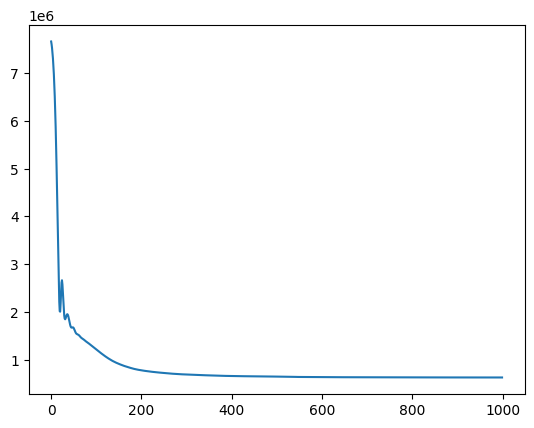

In [ ]:
plt.plot(loss_iter)

In [ ]:
slen = 40
tile_slen = 4
exclude = {'images', 'background', 'paddings', 'centered_sources', 'uncentered_sources', 'noiseless'}
full_catalog = FullCatalog(slen, slen, {p:q for p, q in ds.items() if p not in exclude})
tile_catalog = full_catalog.to_tile_params(tile_slen, ignore_extra_sources=True)

In [ ]:
# now let's check deblender performance
cpu = torch.device("cpu")
model = model.eval().to("cpu")

images =ds['images'].float()
background = ds['background'].float()

with torch.no_grad():
    gparams = model.variational_mode(images, background, tile_catalog)
gparams.shape

torch.Size([10, 10, 10, 8])

In [ ]:
from bliss.render_tiles import render_galaxy_ptiles
from bliss.render_tiles import reconstruct_image_from_ptiles


ptiles = render_galaxy_ptiles(model._dec, tile_catalog.locs, gparams, tile_catalog['galaxy_bools'], 52, 4, )

recon = reconstruct_image_from_ptiles(ptiles, 4)
ptiles.shape, recon.shape

(torch.Size([10, 10, 10, 1, 52, 52]), torch.Size([10, 1, 88, 88]))

In [ ]:
idx = 4
ds['n_sources'][idx]

tensor(3)

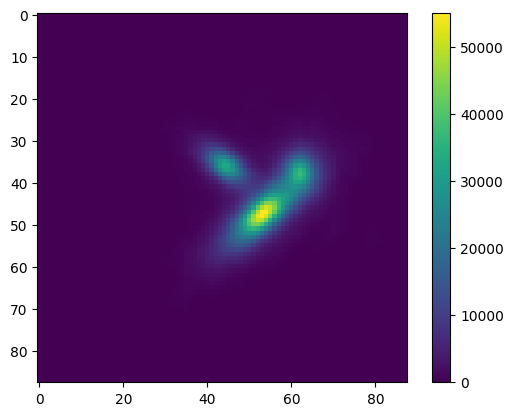

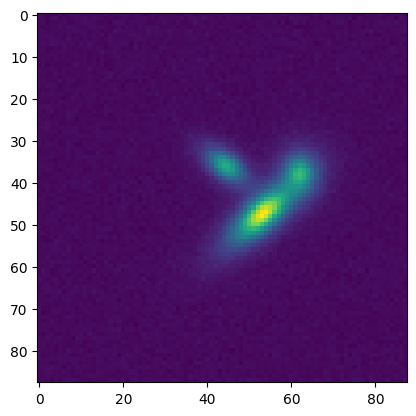

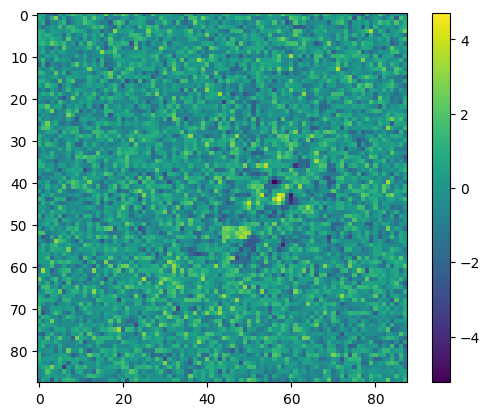

In [ ]:
plt.imshow(recon[idx, 0])
plt.colorbar()
plt.show()
plt.imshow(images[idx, 0] )
plt.show()
x = recon[idx, 0] + ds['background'][idx, 0]
y = images[idx, 0] - ds['paddings'][idx, 0]
plt.imshow( (y - x) / x.sqrt())
plt.colorbar()